# Basic lightcurve

In [8]:
import os
from glob import glob

def init(filedir):
    file_list = glob(os.path.join(filedir,'*.fits'))
    file_list.sort()
    if len(file_list)>0:
        print('raw data frames: {}'.format(len(file_list)))
        
        gband=[]
        rband=[]
        zband=[]
        
        #get list of frames by filter based on header
        for i in tqdm(file_list):
            hdr = pf.open(i)[0].header
            
            if hdr['FILTER'] == 'g':
                gband.append(i)
            elif hdr['FILTER'] == 'r':
                rband.append(i)
            elif hdr['FILTER'] == 'z_s':
                zband.append(i)
            else: #redundancy
                print(i)
        print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))
        
        bands=(gband,rband,zband)
        
    
    else:
        print('ERROR: check your data directory')
        
    return bands

In [9]:
#!usr/bin/python


import numpy as np
from datetime import datetime as dt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


filedir='/mnt/B838B30438B2C124/research/transit/df_HATP44/HATP44_data/'

bands = init(filedir)

  0%|          | 4/1457 [00:00<00:45, 32.11it/s]

raw data frames: 1457


100%|██████████| 1457/1457 [00:20<00:00, 72.72it/s] 

376
704
377


## Crop image

In [10]:
import numpy as np

def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

## Compute Centroid 

In [11]:
from photutils.centroids import centroid_com as com

def get_centroid(image):
    '''
    Calculate the centroid of a 2D array as its “center of mass” determined from image moments.
    '''
    centroid = com(image)
    return centroid

## Do photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)

for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)

In [12]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r):
    fwhm = 8.0
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [13]:
def make_lightcurve(bands, band_idx):
    for star_idx in range(3):
        xcenters, ycenters = [],[]
        aperture_sums = []
        obs_time = []
        obs_mjd = []
        sum_per_band = {}

        ##extract lightcurve (enumerate all frames) in a given band
        for i in tqdm(bands[band_idx]):
            hdr = pf.open(i)[0].header
            img = pf.open(i)[0].data

            #get dates from fits header
            date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
            time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
            newdate = time.replace(year=date.year, month=date.month, day=date.day)
            obs_time.append(newdate)
            obs_mjd.append(hdr['MJD-STRT'])
            
            #crop
            image_crop = get_crop(img, centroids[star_idx], box_size)
            #compute centroid
            centroid = get_centroid(image_crop)
            centroids.append(centroid)

            xcenters.append(centroid[0])
            ycenters.append(centroid[1])

            #do photometry
            aperture_sum = get_phot(image_crop, centroid, r=20)
            aperture_sums.append(aperture_sum)

        #output as dataframe of given band and star
        dfs.append(pd.DataFrame(
            {'{0}_{1}_x'.format(band_name[band_idx], star_names[star_idx]) : xcenters,
             '{0}_{1}_y'.format(band_name[band_idx], star_names[star_idx]) : ycenters,
             '{0}_{1}_flux'.format(band_name[band_idx], star_names[star_idx]) : aperture_sums},
            index = obs_time))
        
    return dfs, band_idx

In [14]:
def plot_lightcurve(dfs, band_idx, showfig=None):
    df = pd.concat(dfs, axis=1)
    #df.head()

    if band_idx==0:
        cols = 'g_a_flux g_b_flux g_c_flux'.split()

    elif band_idx==1:
        cols = 'r_a_flux r_b_flux r_c_flux'.split()

    else:
        cols = 'z_a_flux z_b_flux z_c_flux'.split()
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    if showfig==None or showfig==True:
        df[cols].plot(subplots=True, figsize=(15,8),ax=ax)
        
    return df

In [32]:
def df_phot(target, ref, df, normed, showfig=None):
    if target=='a':
        t=df.columns[0]
    elif target=='b':
        t=df.columns[3]
    else:
        t=df.columns[6]
        
    if ref=='a':
        r=df.columns[0]
    elif ref=='b':
        r=df.columns[3]
    else:
        r=df.columns[6]
    
    #differential photometry
    res=df[t]/df[r]
    
    #normalization
    if normed == True:
        #(res-res.mean())/res.std()
        res = res/res.max().astype(np.float64)
    else:
        pass
    if showfig==None or showfig==True:
        ax2 = res.plot(figsize=(15,5), color='k', marker='o', linestyle='none', title='{}-band'.format(df.columns[0].split('_')[0]))
        ax2.xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
        ax2.set_ylabel('Normalized Flux')
        ax2.set_xlabel('Time (HJD)')
        plt.show()
    return res

100%|██████████| 377/377 [00:23<00:00, 16.30it/s]
/home/jpdl/miniconda3/envs/astroconda/lib/python3.5/site-packages/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


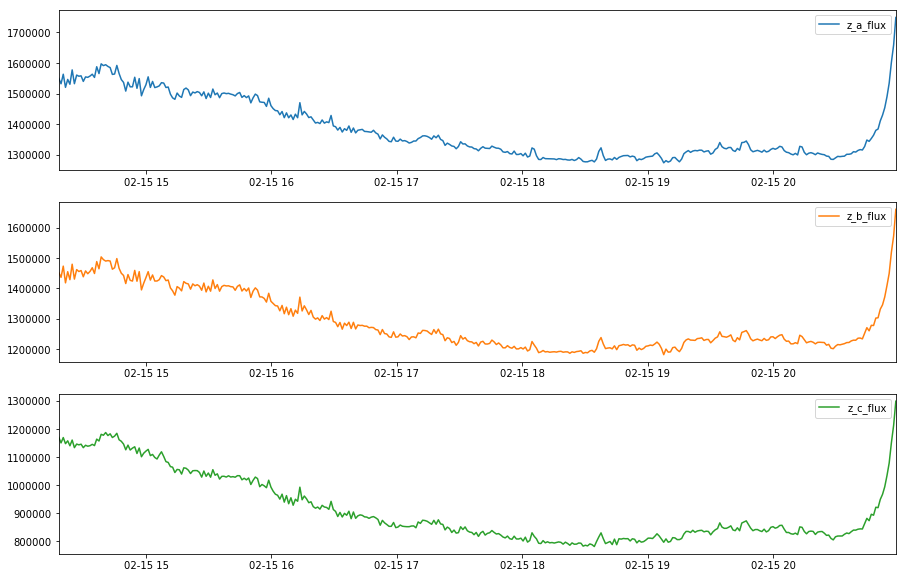

In [16]:
import pandas as pd
#import multiprocessing

box_size = 80
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
star_names = 'abc'

dfs = []

##loop in 3 stars given band  
dfs, band_idx =  make_lightcurve(bands, band_idx=2)

#plot fluxes
df = plot_lightcurve(dfs, band_idx)

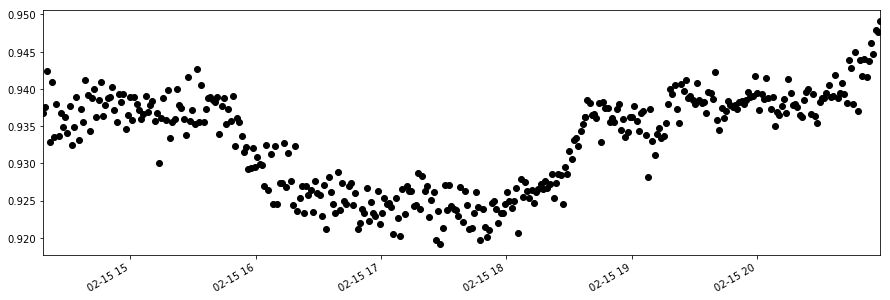

In [27]:
#differential photometry
res = df_phot(target='b', ref='a', df=df, showfig=True)

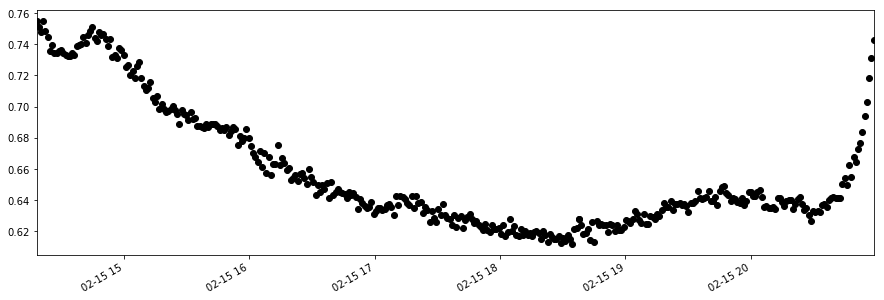

In [29]:
res = df_phot(target='c', ref='a', df=df, showfig=True)

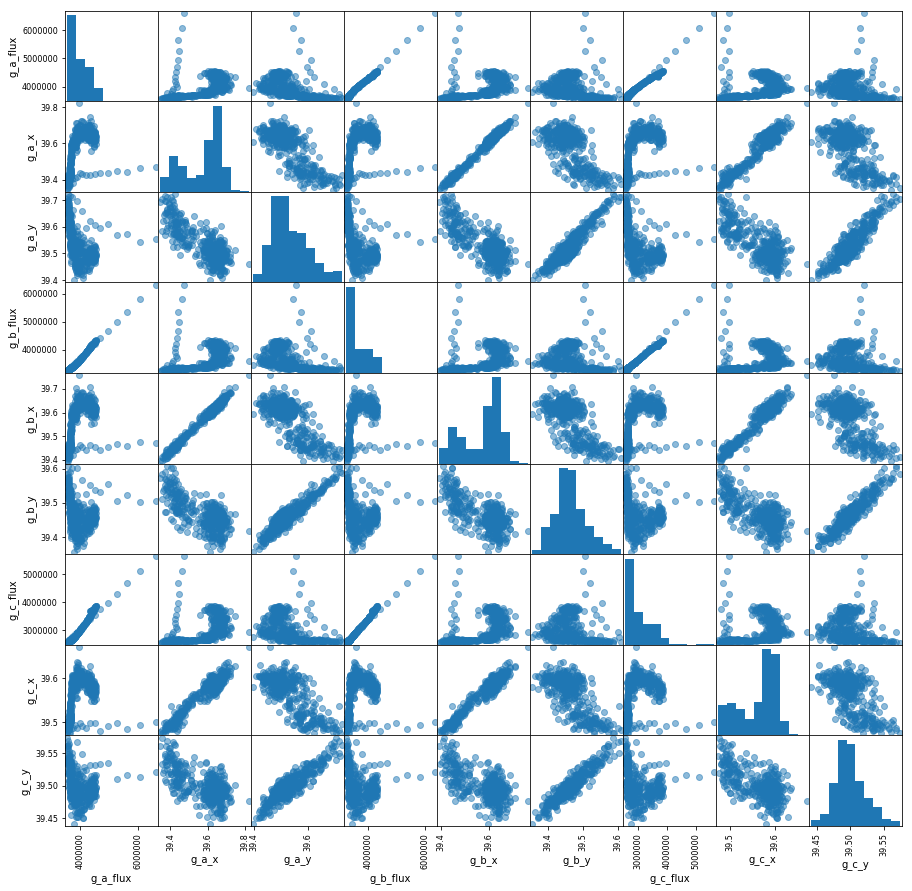

In [28]:
from pandas.tools.plotting import scatter_matrix

def plot_matrix(df):
    scatter_matrix(df, figsize=(15,15), marker='o', alpha=0.5);
    plt.show()

plot_matrix(df_g)

## Analyzing output of moscatel

In [30]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
import pandas as pd
try:
    df_g = pd.read_csv('../scripts/output/df_gband.csv', index_col=0, parse_dates=True)
    df_r = pd.read_csv('../scripts/output/df_rband.csv', index_col=0, parse_dates=True)
    df_z = pd.read_csv('../scripts/output/df_zband.csv', index_col=0, parse_dates=True)
except:
    print('ERROR: check missing data in output folder')

In [22]:
df_grz = df_g.join([df_r, df_z])
#df.index.to_julian_date()

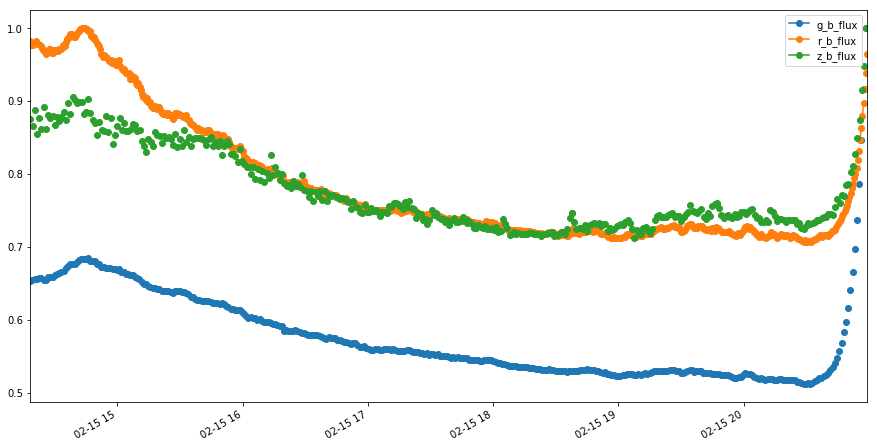

In [33]:
def plot_multicolor(df, star_idx, showfig=None):
    
    if star_idx==0:
        cols = 'g_a_flux r_a_flux z_a_flux'.split()

    elif star_idx==1:
        cols = 'g_b_flux r_b_flux z_b_flux'.split()

    else:
        cols = 'z_c_flux z_c_flux z_c_flux'.split()
    
    if showfig==None or showfig==True:
    	#normalize
    	df = df/df.max().astype(np.float64)
    	axs = df[cols].plot(subplots=False,figsize=(15,8), marker='o')
        #axs.set_ylabel('Raw Flux')
        #axs.set_xlabel('Time (HJD)')
    
    plt.show()

plot_multicolor(df_grz, star_idx=star)

In [49]:
t=df_grz.columns[[3,12,21]]
r=df_grz.columns[[0,9,18]]

df_grz[t]/df_grz[r]

,g_a_flux,g_b_flux,r_a_flux,r_b_flux,z_a_flux,z_b_flux
2017-02-15 14:18:12.963052,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:18:14.529240,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:18:15.853140,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:18:45.888896,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:19:18.961023,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:19:19.198086,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:19:20.626707,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:19:55.560678,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:20:23.215785,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15 14:20:23.220731,NaN,NaN,NaN,NaN,NaN,NaN


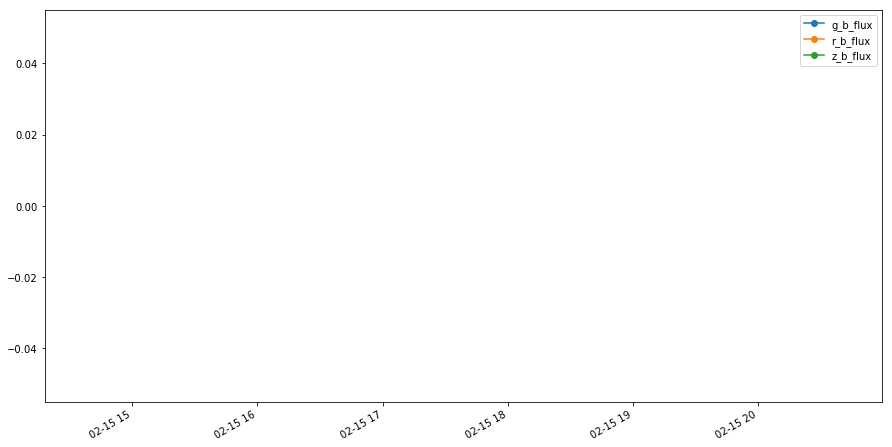

In [44]:
target = 'b'
ref = 'a'
star = 1
normed = True

def df_phot_multicolor(target, ref, df_grz, star, normed, showfig=None):
    if target=='a':
        t=df_grz.columns[[0,9,18]]
    elif target=='b':
        t=df_grz.columns[[3,12,21]]
    else:
        t=df_grz.columns[[6,15,24]]
        
    if ref=='a':
        r=df_grz.columns[[0,9,18]]
    elif ref=='b':
        r=df_grz.columns[[3,12,21]]
    else:
        r=df_grz.columns[[6,15,24]]
    
    #differential photometry
    res_grz=df_grz[t]/df_grz[r]
    
    #normalization
    if normed == True:
        #(res-res.mean())/res.std()
        res_grz = res_grz/res_grz.max().astype(np.float64)
    else:
        pass
    if showfig==None or showfig==True:
        plot_multicolor(res_grz, star, showfig=True)
        
    return res_grz

res_grz = df_phot_multicolor(target, ref, df_grz, star, normed)

Parameters to choose from:
Index(['r_a_flux', 'r_a_x', 'r_a_y', 'r_b_flux', 'r_b_x', 'r_b_y', 'r_c_flux',
       'r_c_x', 'r_c_y'],
      dtype='object')
columns to plot (e.g. r_a_x r_a_y): r_a_x r_a_y


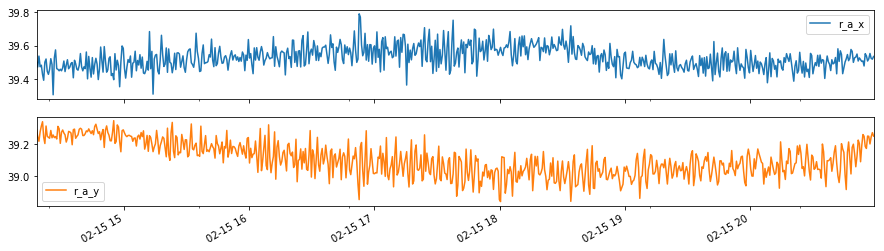

In [27]:
def plot_params(df):
    print('Parameters to choose from:\n{}'.format(df.columns))
    try:
        cols = raw_input('columns to plot (e.g. r_a_x r_a_y): ')
    except:
        cols = input('columns to plot (e.g. r_a_x r_a_y): ')
    cols = cols.split()
    df[cols].plot(subplots=True, figsize=(15,4))
    plt.show()

plot_params(df_r)